### Catboost

In [1]:
!pip install catboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import catboost
from catboost import Pool, CatBoostClassifier, cv
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_path = '/content/gdrive/MyDrive/Colab_Notebooks/News_Analytics_Project/data'

In [5]:
preprocessed_train = pd.read_csv(os.path.join(data_path,'train_preprocess.csv'))
preprocessed_test = pd.read_csv(os.path.join(data_path,'test_preprocess.csv'))

Results of previous classifier models

In [6]:
summary = pd.read_csv(os.path.join(data_path,'summary_ml.csv'))
summary

,model,vectorizer,f1,predicting time
0,LogisticRegression,Tfidf,0.881,2.648436
1,LogisticRegression,Word2Vec with Mean Pooling,0.859,3.920810


We will fit CatboostClassifier with validation on lemmatized docs using default [Text processing](https://catboost.ai/en/docs/references/text-processing__test-processing__default-value) the Catboost library supports and use Optuna Library to tune hyperparameters. 

Train set is 80% and Test and Validation set have 10% of the original collected data. 

In [7]:
X_train = preprocessed_train[['lemmas']]
y_train = preprocessed_train.topic

train_texts, val_texts, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

train = Pool(data=train_texts,
                  label=train_labels,
    text_features=['lemmas'],
)

validation = Pool(data=val_texts,
                       label=val_labels,
    text_features=['lemmas']
)

print('Train dataset shape: {}\n'.format(train.shape))

Train dataset shape: (30391, 1)



In [8]:
def objective(trial):
    params = {
        'loss_function': 'MultiClass',
        'custom_metric': 'F1',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 5, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10),
        'early_stopping_rounds': 300,
        'task_type': 'GPU'
    }

    model = catboost.CatBoostClassifier(**params, random_seed=42)
    model.fit(train, verbose=100, eval_set=validation)
    y_pred = model.predict(validation).flatten()
    return f1_score(y_pred, val_labels, average='macro')

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2023-12-21 10:21:10,556] A new study created in memory with name: no-name-b432fc4f-b8b0-46a7-8008-ce15a49763cf


0:	learn: 1.8908879	test: 1.8904710	best: 1.8904710 (0)	total: 39.6ms	remaining: 39.5s
100:	learn: 0.4950913	test: 0.4830791	best: 0.4830791 (100)	total: 2.01s	remaining: 17.9s
200:	learn: 0.4516231	test: 0.4533499	best: 0.4533499 (200)	total: 3.74s	remaining: 14.9s
300:	learn: 0.4261368	test: 0.4398951	best: 0.4398951 (300)	total: 5.41s	remaining: 12.6s
400:	learn: 0.4043253	test: 0.4291076	best: 0.4291076 (400)	total: 7.07s	remaining: 10.6s
500:	learn: 0.3851177	test: 0.4199595	best: 0.4199595 (500)	total: 8.79s	remaining: 8.75s
600:	learn: 0.3700714	test: 0.4145543	best: 0.4145483 (595)	total: 10.4s	remaining: 6.93s
700:	learn: 0.3572545	test: 0.4099347	best: 0.4099347 (700)	total: 12s	remaining: 5.13s
800:	learn: 0.3449212	test: 0.4060576	best: 0.4060576 (800)	total: 13.6s	remaining: 3.39s
900:	learn: 0.3347283	test: 0.4029061	best: 0.4029061 (900)	total: 15.2s	remaining: 1.67s
999:	learn: 0.3250671	test: 0.3992520	best: 0.3992520 (999)	total: 16.8s	remaining: 0us
bestTest = 0.3992

[I 2023-12-21 10:21:43,043] Trial 0 finished with value: 0.8714868579792134 and parameters: {'learning_rate': 0.07268222670380756, 'depth': 6, 'l2_leaf_reg': 3.814811628513625}. Best is trial 0 with value: 0.8714868579792134.


0:	learn: 1.8884295	test: 1.8833758	best: 1.8833758 (0)	total: 87.3ms	remaining: 1m 27s
100:	learn: 0.4776003	test: 0.4771091	best: 0.4771091 (100)	total: 5.56s	remaining: 49.5s
200:	learn: 0.4235416	test: 0.4442506	best: 0.4442506 (200)	total: 10.3s	remaining: 40.8s
300:	learn: 0.3920216	test: 0.4300080	best: 0.4300080 (300)	total: 14.7s	remaining: 34.2s
400:	learn: 0.3660517	test: 0.4203111	best: 0.4203111 (400)	total: 19.2s	remaining: 28.7s
500:	learn: 0.3443697	test: 0.4127857	best: 0.4127857 (500)	total: 23.7s	remaining: 23.7s
600:	learn: 0.3268688	test: 0.4084123	best: 0.4084123 (600)	total: 28.2s	remaining: 18.7s
700:	learn: 0.3115279	test: 0.4034992	best: 0.4034992 (700)	total: 32.6s	remaining: 13.9s
800:	learn: 0.2978716	test: 0.4003486	best: 0.4003486 (800)	total: 36.9s	remaining: 9.18s
900:	learn: 0.2856994	test: 0.3976723	best: 0.3975260 (895)	total: 41.2s	remaining: 4.53s
999:	learn: 0.2754413	test: 0.3950405	best: 0.3949850 (991)	total: 45.5s	remaining: 0us
bestTest = 0.3

[I 2023-12-21 10:22:43,911] Trial 1 finished with value: 0.8702469543385649 and parameters: {'learning_rate': 0.05961832921746022, 'depth': 9, 'l2_leaf_reg': 5.384851680995688}. Best is trial 0 with value: 0.8714868579792134.


0:	learn: 1.7024133	test: 1.6942233	best: 1.6942233 (0)	total: 87ms	remaining: 1m 26s
100:	learn: 0.4412662	test: 0.4553560	best: 0.4553560 (100)	total: 5.28s	remaining: 47s
200:	learn: 0.3869189	test: 0.4297075	best: 0.4297075 (200)	total: 9.83s	remaining: 39.1s
300:	learn: 0.3517882	test: 0.4172533	best: 0.4172533 (300)	total: 14.2s	remaining: 33.1s
400:	learn: 0.3254231	test: 0.4100987	best: 0.4100987 (400)	total: 18.6s	remaining: 27.8s
500:	learn: 0.3037158	test: 0.4047857	best: 0.4047857 (500)	total: 22.9s	remaining: 22.8s
600:	learn: 0.2839313	test: 0.4001339	best: 0.4001029 (599)	total: 27.3s	remaining: 18.1s
700:	learn: 0.2675992	test: 0.3969286	best: 0.3969286 (700)	total: 31.5s	remaining: 13.4s
800:	learn: 0.2528363	test: 0.3934567	best: 0.3934567 (800)	total: 35.8s	remaining: 8.89s
900:	learn: 0.2398157	test: 0.3910810	best: 0.3910810 (900)	total: 40.2s	remaining: 4.42s
999:	learn: 0.2286988	test: 0.3891007	best: 0.3890688 (995)	total: 44.4s	remaining: 0us
bestTest = 0.38906

[I 2023-12-21 10:23:43,843] Trial 2 finished with value: 0.8710723654966626 and parameters: {'learning_rate': 0.0982687778546154, 'depth': 9, 'l2_leaf_reg': 5.8474552118748875}. Best is trial 0 with value: 0.8714868579792134.


0:	learn: 1.9817603	test: 1.9804757	best: 1.9804757 (0)	total: 39.3ms	remaining: 39.3s
100:	learn: 0.5293034	test: 0.5097658	best: 0.5097658 (100)	total: 2.66s	remaining: 23.7s
200:	learn: 0.4802728	test: 0.4709163	best: 0.4709163 (200)	total: 4.89s	remaining: 19.4s
300:	learn: 0.4538550	test: 0.4543869	best: 0.4543869 (300)	total: 7.06s	remaining: 16.4s
400:	learn: 0.4354294	test: 0.4438098	best: 0.4438098 (400)	total: 9.24s	remaining: 13.8s
500:	learn: 0.4191776	test: 0.4349200	best: 0.4349200 (500)	total: 11.4s	remaining: 11.3s
600:	learn: 0.4067252	test: 0.4295012	best: 0.4295012 (600)	total: 13.5s	remaining: 8.99s
700:	learn: 0.3958292	test: 0.4249397	best: 0.4249397 (700)	total: 15.7s	remaining: 6.69s
800:	learn: 0.3855068	test: 0.4203919	best: 0.4203919 (800)	total: 17.8s	remaining: 4.42s
900:	learn: 0.3764360	test: 0.4167016	best: 0.4167016 (900)	total: 19.9s	remaining: 2.19s
999:	learn: 0.3681781	test: 0.4131187	best: 0.4131187 (999)	total: 22s	remaining: 0us
bestTest = 0.4131

[I 2023-12-21 10:24:21,110] Trial 3 finished with value: 0.8689273244982681 and parameters: {'learning_rate': 0.04529057663747355, 'depth': 7, 'l2_leaf_reg': 7.832397659072333}. Best is trial 0 with value: 0.8714868579792134.


0:	learn: 2.0132010	test: 2.0121451	best: 2.0121451 (0)	total: 24.9ms	remaining: 24.9s
100:	learn: 0.5459111	test: 0.5239142	best: 0.5239142 (100)	total: 1.57s	remaining: 14s
200:	learn: 0.4971190	test: 0.4811261	best: 0.4811261 (200)	total: 2.9s	remaining: 11.5s
300:	learn: 0.4727116	test: 0.4633176	best: 0.4633176 (300)	total: 4.22s	remaining: 9.8s
400:	learn: 0.4557244	test: 0.4514688	best: 0.4514601 (399)	total: 5.55s	remaining: 8.29s
500:	learn: 0.4414320	test: 0.4420911	best: 0.4420792 (499)	total: 6.84s	remaining: 6.81s
600:	learn: 0.4294326	test: 0.4355290	best: 0.4355280 (599)	total: 8.13s	remaining: 5.39s
700:	learn: 0.4193055	test: 0.4305756	best: 0.4305756 (700)	total: 9.43s	remaining: 4.02s
800:	learn: 0.4102642	test: 0.4264821	best: 0.4264719 (799)	total: 10.7s	remaining: 2.66s
900:	learn: 0.4019816	test: 0.4228636	best: 0.4228636 (900)	total: 12s	remaining: 1.32s
999:	learn: 0.3943776	test: 0.4194560	best: 0.4194560 (999)	total: 13.3s	remaining: 0us
bestTest = 0.41945600

[I 2023-12-21 10:24:49,679] Trial 4 finished with value: 0.8666101506222899 and parameters: {'learning_rate': 0.0494715020211662, 'depth': 5, 'l2_leaf_reg': 5.184354042643451}. Best is trial 0 with value: 0.8714868579792134.


0:	learn: 1.8756035	test: 1.8751693	best: 1.8751693 (0)	total: 29.9ms	remaining: 29.9s
100:	learn: 0.4900956	test: 0.4807940	best: 0.4807940 (100)	total: 1.94s	remaining: 17.2s
200:	learn: 0.4442681	test: 0.4494654	best: 0.4494654 (200)	total: 3.62s	remaining: 14.4s
300:	learn: 0.4174767	test: 0.4351995	best: 0.4351995 (300)	total: 5.24s	remaining: 12.2s
400:	learn: 0.3957646	test: 0.4250485	best: 0.4250485 (400)	total: 6.86s	remaining: 10.3s
500:	learn: 0.3771983	test: 0.4169032	best: 0.4169032 (500)	total: 8.46s	remaining: 8.43s
600:	learn: 0.3620910	test: 0.4118817	best: 0.4118817 (600)	total: 10.1s	remaining: 6.68s
700:	learn: 0.3483406	test: 0.4073936	best: 0.4073936 (700)	total: 11.7s	remaining: 4.98s
800:	learn: 0.3363777	test: 0.4030902	best: 0.4030902 (800)	total: 13.3s	remaining: 3.31s
900:	learn: 0.3254600	test: 0.3997911	best: 0.3997911 (900)	total: 14.9s	remaining: 1.64s
999:	learn: 0.3155657	test: 0.3967326	best: 0.3967326 (999)	total: 16.6s	remaining: 0us
bestTest = 0.39

[I 2023-12-21 10:25:21,659] Trial 5 finished with value: 0.8721107576311358 and parameters: {'learning_rate': 0.07641958651588322, 'depth': 6, 'l2_leaf_reg': 3.4036140491799403}. Best is trial 5 with value: 0.8721107576311358.


0:	learn: 1.9017160	test: 1.8978989	best: 1.8978989 (0)	total: 56.7ms	remaining: 56.6s
100:	learn: 0.4983522	test: 0.4879278	best: 0.4879278 (100)	total: 3.72s	remaining: 33.1s
200:	learn: 0.4497355	test: 0.4548426	best: 0.4548426 (200)	total: 6.8s	remaining: 27s
300:	learn: 0.4212086	test: 0.4398599	best: 0.4398599 (300)	total: 9.83s	remaining: 22.8s
400:	learn: 0.3984719	test: 0.4284847	best: 0.4284847 (400)	total: 12.8s	remaining: 19.1s
500:	learn: 0.3799670	test: 0.4203560	best: 0.4203560 (500)	total: 15.7s	remaining: 15.7s
600:	learn: 0.3642184	test: 0.4146672	best: 0.4146672 (600)	total: 18.7s	remaining: 12.4s
700:	learn: 0.3499565	test: 0.4089360	best: 0.4089360 (700)	total: 21.7s	remaining: 9.25s
800:	learn: 0.3381019	test: 0.4053916	best: 0.4053916 (800)	total: 24.6s	remaining: 6.12s
900:	learn: 0.3277232	test: 0.4023631	best: 0.4023631 (900)	total: 27.5s	remaining: 3.02s
999:	learn: 0.3182604	test: 0.3996435	best: 0.3996435 (999)	total: 30.4s	remaining: 0us
bestTest = 0.39964

[I 2023-12-21 10:26:07,306] Trial 6 finished with value: 0.868566289529005 and parameters: {'learning_rate': 0.05783962364576546, 'depth': 8, 'l2_leaf_reg': 7.0752076684105685}. Best is trial 5 with value: 0.8721107576311358.


0:	learn: 1.7598587	test: 1.7525743	best: 1.7525743 (0)	total: 88.4ms	remaining: 1m 28s
100:	learn: 0.4598877	test: 0.4650070	best: 0.4650070 (100)	total: 5.39s	remaining: 48s
200:	learn: 0.4058741	test: 0.4375489	best: 0.4375489 (200)	total: 9.99s	remaining: 39.7s
300:	learn: 0.3719976	test: 0.4234065	best: 0.4234065 (300)	total: 14.5s	remaining: 33.6s
400:	learn: 0.3465198	test: 0.4153084	best: 0.4153084 (400)	total: 18.9s	remaining: 28.3s
500:	learn: 0.3246904	test: 0.4086171	best: 0.4086171 (500)	total: 23.3s	remaining: 23.2s
600:	learn: 0.3066284	test: 0.4036157	best: 0.4036157 (600)	total: 27.6s	remaining: 18.3s
700:	learn: 0.2904371	test: 0.3999602	best: 0.3999602 (700)	total: 32s	remaining: 13.6s
800:	learn: 0.2760445	test: 0.3967200	best: 0.3966923 (785)	total: 36.3s	remaining: 9.01s
900:	learn: 0.2635749	test: 0.3946877	best: 0.3946877 (900)	total: 40.5s	remaining: 4.45s
999:	learn: 0.2525459	test: 0.3927634	best: 0.3927538 (992)	total: 44.7s	remaining: 0us
bestTest = 0.39275

[I 2023-12-21 10:27:07,558] Trial 7 finished with value: 0.8699566345767026 and parameters: {'learning_rate': 0.08644886146700106, 'depth': 9, 'l2_leaf_reg': 6.888188085420663}. Best is trial 5 with value: 0.8721107576311358.


0:	learn: 1.8823849	test: 1.8819317	best: 1.8819317 (0)	total: 30.2ms	remaining: 30.1s
100:	learn: 0.4979126	test: 0.4840039	best: 0.4840039 (100)	total: 1.91s	remaining: 17s
200:	learn: 0.4540475	test: 0.4533882	best: 0.4533882 (200)	total: 3.54s	remaining: 14.1s
300:	learn: 0.4283783	test: 0.4397465	best: 0.4397137 (299)	total: 5.14s	remaining: 11.9s
400:	learn: 0.4079642	test: 0.4297406	best: 0.4297406 (400)	total: 6.77s	remaining: 10.1s
500:	learn: 0.3906263	test: 0.4210473	best: 0.4210473 (500)	total: 8.4s	remaining: 8.37s
600:	learn: 0.3757911	test: 0.4152505	best: 0.4152480 (598)	total: 9.99s	remaining: 6.63s
700:	learn: 0.3627178	test: 0.4102423	best: 0.4102423 (700)	total: 11.6s	remaining: 4.94s
800:	learn: 0.3511102	test: 0.4068152	best: 0.4068152 (800)	total: 13.2s	remaining: 3.27s
900:	learn: 0.3410255	test: 0.4039640	best: 0.4039640 (900)	total: 14.7s	remaining: 1.62s
999:	learn: 0.3314015	test: 0.4004546	best: 0.4004546 (999)	total: 16.3s	remaining: 0us
bestTest = 0.40045

[I 2023-12-21 10:27:38,995] Trial 8 finished with value: 0.8703480666816765 and parameters: {'learning_rate': 0.07501990443131994, 'depth': 6, 'l2_leaf_reg': 4.894309244978513}. Best is trial 5 with value: 0.8721107576311358.


0:	learn: 2.0662231	test: 2.0660497	best: 2.0660497 (0)	total: 29.9ms	remaining: 29.9s
100:	learn: 0.5877802	test: 0.5647810	best: 0.5647810 (100)	total: 2.01s	remaining: 17.9s
200:	learn: 0.5181769	test: 0.5009980	best: 0.5009980 (200)	total: 3.71s	remaining: 14.8s
300:	learn: 0.4915222	test: 0.4789432	best: 0.4789432 (300)	total: 5.35s	remaining: 12.4s
400:	learn: 0.4740218	test: 0.4667038	best: 0.4667038 (400)	total: 6.98s	remaining: 10.4s
500:	learn: 0.4599628	test: 0.4563083	best: 0.4563083 (500)	total: 8.61s	remaining: 8.58s
600:	learn: 0.4487800	test: 0.4493362	best: 0.4493362 (600)	total: 10.2s	remaining: 6.8s
700:	learn: 0.4393141	test: 0.4440905	best: 0.4440905 (700)	total: 11.8s	remaining: 5.05s
800:	learn: 0.4306338	test: 0.4393086	best: 0.4393086 (800)	total: 13.5s	remaining: 3.34s
900:	learn: 0.4225563	test: 0.4346918	best: 0.4346918 (900)	total: 15.1s	remaining: 1.66s
999:	learn: 0.4155846	test: 0.4312810	best: 0.4312810 (999)	total: 16.7s	remaining: 0us
bestTest = 0.431

[I 2023-12-21 10:28:10,828] Trial 9 finished with value: 0.8670762997593475 and parameters: {'learning_rate': 0.030543690779106007, 'depth': 6, 'l2_leaf_reg': 7.047808990835902}. Best is trial 5 with value: 0.8721107576311358.


In [9]:
study.best_params

{'learning_rate': 0.07641958651588322,
 'depth': 6,
 'l2_leaf_reg': 3.4036140491799403}

In [10]:
X_train = preprocessed_train[['lemmas']]
y_train = preprocessed_train.topic
X_test = preprocessed_test[['lemmas']]
y_test = preprocessed_test.topic

train = Pool(data=X_train,
                  label=y_train,
    text_features=['lemmas'],
)

test = Pool(data=X_test,
            label=y_test,
    text_features=['lemmas']
)

0:	learn: 1.8755054	total: 31.5ms	remaining: 31.4s
100:	learn: 0.4840533	total: 1.96s	remaining: 17.5s
200:	learn: 0.4399285	total: 3.59s	remaining: 14.2s
300:	learn: 0.4123161	total: 5.13s	remaining: 11.9s
400:	learn: 0.3909752	total: 6.64s	remaining: 9.9s
500:	learn: 0.3748323	total: 8.16s	remaining: 8.11s
600:	learn: 0.3608916	total: 9.66s	remaining: 6.39s
700:	learn: 0.3486908	total: 11.2s	remaining: 4.74s
800:	learn: 0.3364602	total: 12.7s	remaining: 3.13s
900:	learn: 0.3263846	total: 14.2s	remaining: 1.54s
998:	learn: 0.3171281	total: 15.6s	remaining: 0us
F1 Score Macro Average: 0.875
                precision    recall  f1-score   support

       culture       0.92      0.95      0.94       941
defense_safety       0.87      0.85      0.86       960
       economy       0.87      0.93      0.90       941
     incidents       0.86      0.92      0.89       946
      politics       0.79      0.82      0.81       993
      religion       0.97      0.95      0.96       917
       sc

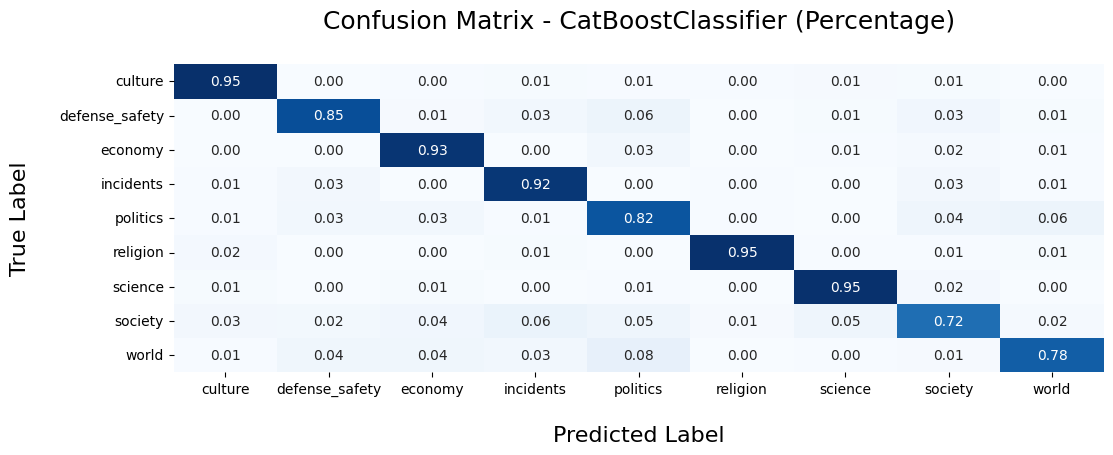

In [11]:
best_params = {
  'learning_rate':  0.07641958651588322,
  'depth': 6,
  'l2_leaf_reg': 3.4036140491799403,
  'loss_function': 'MultiClass',
  'custom_metric': 'F1',
  'iterations': 999,
  'task_type': 'GPU'
            }

best_model = catboost.CatBoostClassifier(**best_params, random_seed=42)
best_model.fit(train, verbose=100)

start_time = time.time()
y_pred = best_model.predict(test)
predicting_time = time.time() - start_time
f1score = round(f1_score(y_test, y_pred, average='macro'), 3)
result_df = pd.DataFrame({'model': ['CatBoostClassifier'],
                              'vectorizer': ['NaiveBayes built-in CatBoostClassifier'],
                              'f1': [f1score],
                             'predicting time':[predicting_time]})
summary = pd.concat([summary, result_df], ignore_index=True)

print(f'F1 Score Macro Average: {f1score}')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(data=cm_percentage, columns=np.unique(y_test), index=np.unique(y_pred))
plt.figure(figsize=(12, 4))
sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.xlabel('\nPredicted Label', fontsize=16)
plt.ylabel('True Label\n', fontsize=16)
plt.title(f'Confusion Matrix - CatBoostClassifier (Percentage)\n', fontsize=18)
plt.show();

In [12]:
summary

,model,vectorizer,f1,predicting time
0,LogisticRegression,Tfidf,0.881,2.648436
1,LogisticRegression,Word2Vec with Mean Pooling,0.859,3.920810
2,CatBoostClassifier,NaiveBayes built-in CatBoostClassifier,0.875,0.837941


The results of CatBoostClassifier on lemmatized docs with built-in text featurizing is a bit worse.

In [13]:
summary.to_csv(os.path.join(data_path,'summary_ml.csv'), index=False)